# Dependencies

In [3]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
import librosa as lr
import librosa.feature as lrf
from scipy.signal import welch
import pywt
from pywt import *
from scipy.signal import periodogram
#from pyemd import emd
from scipy.signal import hilbert
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import nolds
from pyentrp import entropy as ent
from scipy.signal import detrend
from nolds import dfa

# Feature Extraction

In [4]:
# hedef: feature extractionda butun featurelari cikart, csvde hepsine isim ver, training datasi hazirlarken csvden ihtiyac olani kullan
def feature_extraction(signal):
    
    n_mfcc = 5 
    feature_vector = {}
    sr = 128
    # Timbral Texture Features
    
    # 0 indices are due to array shape
    feature_vector['spc_cnt'] = lrf.spectral_centroid(y=signal, sr=sr)[0][0] # Spectral Centroid
    feature_vector['spc_roff'] = lrf.spectral_rolloff(y=signal, sr=sr)[0][0] # Rolloff
    feature_vector['zc']  = np.array(np.sum(np.abs(np.diff(np.sign(signal)))) / (2 * len(signal)))
    
    for idx, mfcc in enumerate(lrf.mfcc(y=signal, n_mfcc=n_mfcc, sr=sr)): # First 5 MFCCs
        feature_vector['mfcc_' + str(idx)] = mfcc[0]
    
    for idx, chroma in enumerate(lrf.chroma_stft(y=signal, n_chroma=15, sr=sr)): #chromagram
        feature_vector['chr_' + str(idx)] = chroma[0]

    n_mel = 10
    for idx, mel in enumerate(lr.power_to_db(lrf.melspectrogram(y=signal, sr=sr))[:n_mel, :]):
        feature_vector['mel_' + str(idx)] = mel[0]
    
    frequency_bands = {
    'gamma': (30,64),
    'beta': (13, 30),
    'alpha': (8, 13),
    'theta': (4, 8),
    'delta': (1, 4),
    }

    # Iterate over each frequency band
    band_powers = {}
    sampling_frequency = 128

    # Calculate the power spectral density (PSD) using Welch's method
    frequencies, psd = welch(signal, fs=sampling_frequency, nperseg=1024)
    

    # Iterate over each frequency band
    # iterations are reversed due to performance differences in certain models
    # TODO: reversing process should be improved, way too clunky rn.
    for band, (low_freq, high_freq) in reversed(frequency_bands.items()):
        # Find indices corresponding to the specified frequency range
        band_indices = np.where((frequencies >= low_freq) & (frequencies < high_freq))
        # Integrate PSD within the band's frequency range to compute band power
        band_power = np.trapz(psd[band_indices], frequencies[band_indices])
        band_powers[band] = band_power
        feature_vector[band + '_power'] = band_power
    
    for band in reversed(list(band_powers)):
        for child_band in reversed(list(band_powers)):
            if child_band == band:
                continue
            feature_vector[band + '_' + child_band] = band_powers[band]/ band_powers[child_band]
        band_powers.pop(band)
    
    
    # Calculate the first differences
    first_differences = np.diff(signal, n=1)

    # Calculate the mean of the absolute values of the first differences
    feature_vector['mean_abs_sec_dif'] = np.mean(np.abs(first_differences))

    feature_vector['dfa'] = dfa(signal, overlap=False)

    

    return feature_vector
    
    # rejected features, discuss whether to include them in the paper or not.

    #feature_vector.append([np.mean(signal)]) #no
    #feature_vector.append([np.var(signal)]) #no
    #feature_vector.append([stats.skew(signal)]) #no
    #feature_vector.append([stats.kurtosis(signal)]) #no

    #activity, mobility, complexity = hjorth_parameters(signal) #no
    #feature_vector.append([activity]) #no
    #feature_vector.append([mobility]) #no
    #feature_vector.append([complexity]) #no

    #feature_vector.append([np.sqrt(np.mean(signal**2))]) #no
    #feature_vector.append(lr.beat.tempo(signal)) # Tempo #bu kötü yapiyor

    #for tonal in lrf.tonnetz(signal)[:n_tonnetz, :] : #daha kötü gibi
    #    feature_vector.append(tonal)

    '''
    [cA5, cD5, cD4, cD3, cD2, cD1] = wavedec(signal, 'db1', level=5)
    coeffs = [cA5, cD5, cD4, cD3, cD2, cD1]
    db1 = pywt.Wavelet('db1')
    
    re0 = pywt.waverec([coeffs[0]], db1)
    re1 = pywt.waverec([coeffs[1]], db1)
    re2 = pywt.waverec([coeffs[2]], db1)
    re3 = pywt.waverec([coeffs[3]], db1)
    re4 = pywt.waverec([coeffs[4]], db1)
    re5 = pywt.waverec([coeffs[5]], db1)

    re0_p = np.sum(np.power(re0,2)/len(re0))
    re1_p = np.sum(np.power(re1,2)/len(re1))
    re2_p = np.sum(np.power(re2,2)/len(re2))
    re3_p = np.sum(np.power(re3,2)/len(re3))
    re4_p = np.sum(np.power(re4,2)/len(re4))
    re5_p = np.sum(np.power(re5,2)/len(re5))
    
    feature_vector.append([[re0_p]])
    feature_vector.append([[re1_p]])
    feature_vector.append([[re2_p]])
    feature_vector.append([[re3_p]])
    feature_vector.append([[re4_p]])
    feature_vector.append([[re5_p]])
    
    feature_vector.append([[re5_p/re4_p]])
    feature_vector.append([[re5_p/re3_p]])
    feature_vector.append([[re5_p/re2_p]])
    feature_vector.append([[re5_p/re1_p]])
    feature_vector.append([[re5_p/re0_p]])
    feature_vector.append([[re4_p/re3_p]])
    feature_vector.append([[re4_p/re2_p]])
    feature_vector.append([[re4_p/re1_p]])
    feature_vector.append([[re4_p/re0_p]])
    feature_vector.append([[re3_p/re2_p]])
    feature_vector.append([[re3_p/re1_p]])
    feature_vector.append([[re3_p/re0_p]])
    feature_vector.append([[re2_p/re1_p]])
    feature_vector.append([[re2_p/re0_p]])
    feature_vector.append([[re1_p/re0_p]])
    '''


    # hata veren featureler

    '''    
    
    # Rhythymic Content Features
    peaks = -np.sort(-lr.onset.onset_strength(signal, sr = 128))
    A0 = peaks[0]
    A1 = peaks[1]
    RA = A1/A0    
    
    extracted_features.append(np.mean(lrf.tempogram(signal)))
    extracted_features.append(A0)
    extracted_features.append(A1)
    extracted_features.append(RA)

    '''


    #feature_vector.append([lr.onset.onset_strength(signal)]) # Flux
    #feature_vector.append(lr.feature.zero_crossing_rate(signal)) # Zero Crossings

# Dataset Preparation

## I/O

In [7]:
dataset_path = 'drowsiness-dataset.mat' # changed to relative path
data_dict = scipy.io.loadmat(dataset_path)
subjects = list(data_dict["subindex"])
states = [i[0] for i in data_dict["substate"]]
eeg = data_dict["EEGsample"]

## Channel Selection

In [8]:
channel_names =  ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FT7", "FC3", "FCZ", "FC4", "FT8", "T3", "C3", "Cz", "C4", "T4", "TP7", "CP3", "CPz", "CP4", "TP8", "T5", "P3", "PZ", "P4", "T6", "O1", "Oz" , "O2"]
channel_idx =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
channel_names = dict(zip(channel_names, channel_idx))

def select_channel(data, channel_list):
    selection = []
    channel_col = []
    for i in range(len(channel_list)):
        selection.append(data[:, channel_names[channel_list[i]], :])
        channel_col.append([channel_list[i]] * data.shape[0])
    selected_data = np.concatenate(selection)
    channel_col = np.concatenate(channel_col)
    return selected_data, channel_col

channel_list = ['F3', 'F4', 'C3', 'Cz', 'Oz']
labels = states * len(channel_list)
data, channel_col = select_channel(eeg, channel_list)

## Extraction on Selected Channels

In [9]:
# extracted features np array olabilir liste yerine
import time
start = time.time()
extracted_features = []
for i in range(data.shape[0]):
    signal_features = feature_extraction(data[i,:])
    extracted_features.append(signal_features)

end = time.time()
print(end-start)

223.049663066864


In [10]:
df = pd.DataFrame.from_records(extracted_features).fillna(0)
df.insert(loc = 0, column = 'channels', value = channel_col)
df['label'] = labels
df.to_csv("eeg_features.csv")

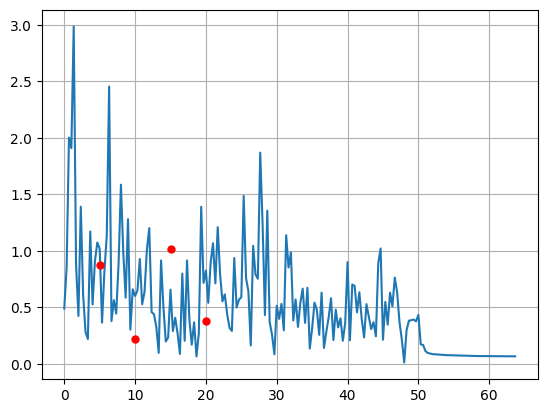

In [96]:
y = data[1, :]

from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 128*3
# sample spacing
T = 1.0 / 128.0
x = np.linspace(0.0, N*T, N, endpoint=False)
#y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
ya = 2.0/N * np.abs(yf[0:N//2])
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, ya)
peaks, _ = scipy.signal.find_peaks(yf, height=1)
peaks = [5, 10, 15, 20]

plt.plot(peaks, ya[peaks], 'ro', label='Selected Points', markersize=5)
plt.grid()
plt.show()